# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places
- different blur levels- complete
- different blur levels in the same image
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
training_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with perception loss and multifuz acc training.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(rand_scale_factor)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(height,width)
        

        rand_center = (random.uniform(0,width),random.uniform(0,height))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blur = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blur = cv2.multiply(img_cv_blur, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv = cv2.multiply(img_cv, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        
        img_cv = cv2.add(img_cv, img_cv_blur, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (1280, 720)


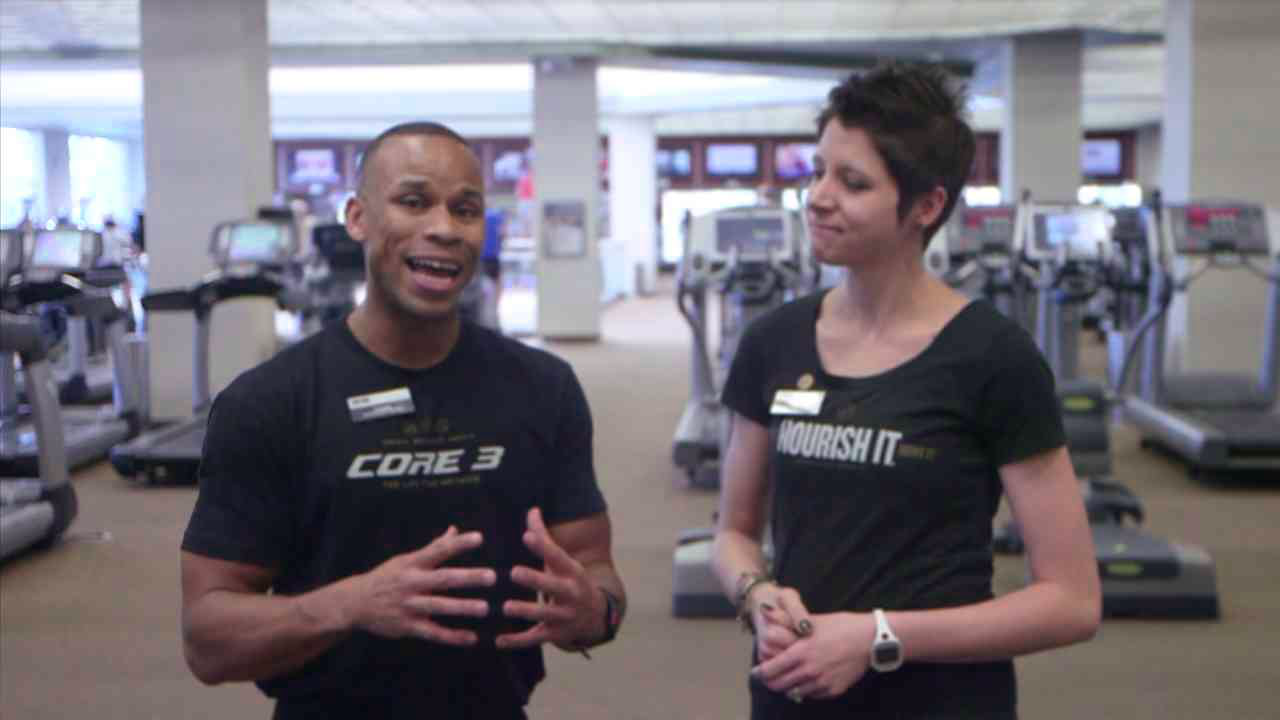

In [19]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (720,1280),
                  kernel_range=(4,16), 
                  quality_range=(2,2), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.25),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [20]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.25),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [21]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(4,16)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [22]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [23]:
#Define the relationship between image size and batch size
im_batch = [[(480//8,720//8), 256],
            [(480//4,720//4), 64],
            [(480//2,720//2), 16],
            [(480,720), 4]]

In [24]:
im_batch[0][0]

(60, 90)

In [ ]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [25]:
# smaller and faster
crop_size=(480//8,720//8)
batch_size = 4*64
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(60, 90)


In [26]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [27]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

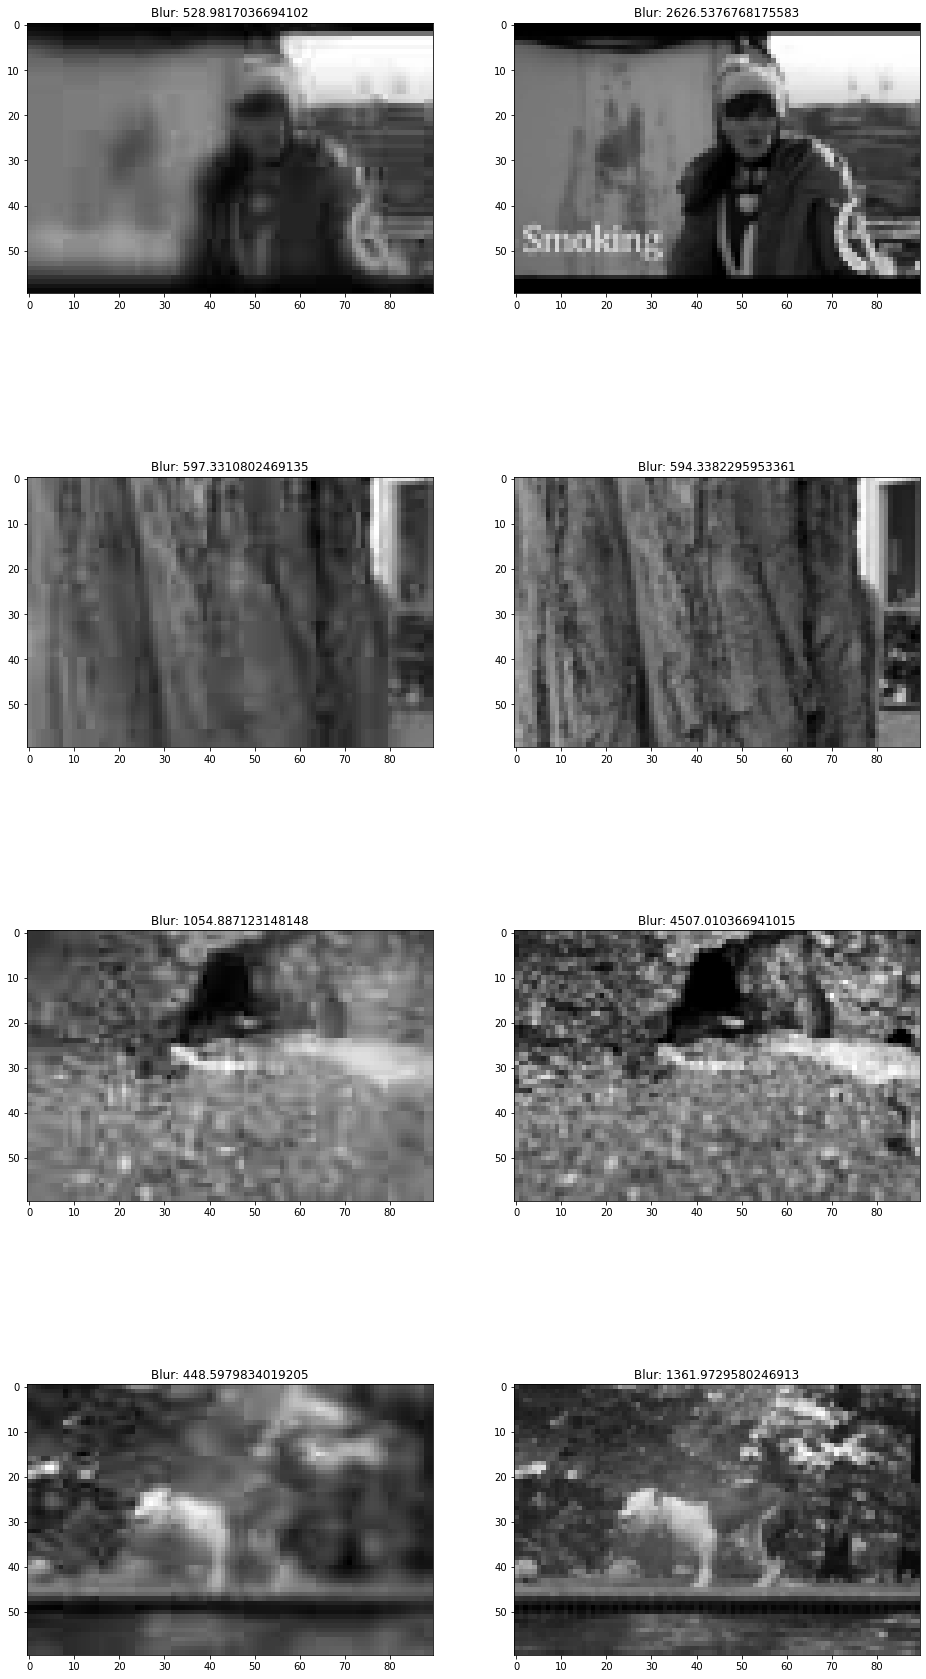

In [28]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [29]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [30]:
#need to try this
# from https://github.com/xiezw5/Component-Divide-and-Conquer-for-Real-World-Image-Super-Resolution/blob/master/CDC/modules/loss.py

class GradientPenaltyLoss(nn.Module):
    def __init__(self, device=torch.device('cpu')):
        super(GradientPenaltyLoss, self).__init__()
        self.register_buffer('grad_outputs', torch.Tensor())
        self.grad_outputs = self.grad_outputs.to(device)

    def get_grad_outputs(self, input):
        if self.grad_outputs.size() != input.size():
            self.grad_outputs.resize_(input.size()).fill_(1.0)
        return self.grad_outputs

    def forward(self, interp, interp_crit):
        grad_outputs = self.get_grad_outputs(interp_crit)
        grad_interp = torch.autograd.grad(outputs=interp_crit, inputs=interp, \
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
        grad_interp = grad_interp.view(grad_interp.size(0), -1)
        grad_interp_norm = grad_interp.norm(2, dim=1)

        loss = ((grad_interp_norm - 1)**2).mean()
        return loss

In [ ]:




loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [ ]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        return totloss

In [40]:
criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

In [31]:
#criterion = P_Loss()

#criterion.cuda()

In [41]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 2

In [42]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [43]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [44]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [45]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "percepfuzmodel1_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [46]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [47]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [48]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()
# smaller and faster
crop_size=im_batch[0][0]
batch_size = im_batch[0][1]
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)


for epoch in range(1, 6+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

(60, 90)
Start Time: 2020-09-21 18:20:40.387199
Epoch = 1, lr = 0.001
===> Time: 2020-09-21 18:23:38.918115 Epoch[1](10/25): LR: 0.001 : Loss: 58.8648185730
===> Time: 2020-09-21 18:26:28.977494 Epoch[1](20/25): LR: 0.001 : Loss: 191.3354187012
Epoch Loss: tensor(127.7968, device='cuda:0')
Checkpoint saved to checkpoint/percepfuzmodel1_epoch_1.pth
Start Time: 2020-09-21 18:27:48.966208
Epoch = 2, lr = 0.001
===> Time: 2020-09-21 18:30:34.399330 Epoch[2](10/25): LR: 0.001 : Loss: 51.0998573303
===> Time: 2020-09-21 18:33:19.579747 Epoch[2](20/25): LR: 0.001 : Loss: 52.1764030457
Epoch Loss: tensor(50.2291, device='cuda:0')
Checkpoint saved to checkpoint/percepfuzmodel1_epoch_2.pth
Start Time: 2020-09-21 18:34:36.584708
Epoch = 3, lr = 0.001
===> Time: 2020-09-21 18:37:18.744901 Epoch[3](10/25): LR: 0.001 : Loss: 50.6014595032
===> Time: 2020-09-21 18:40:00.546367 Epoch[3](20/25): LR: 0.001 : Loss: 50.5258445740
Epoch Loss: tensor(49.4672, device='cuda:0')
Checkpoint saved to checkpoint/

In [55]:
crop_size=im_batch[1][0]
batch_size = im_batch[1][1]
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

for epoch in range(7, 12+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

(120, 180)
Start Time: 2020-09-21 20:40:23.263005
Epoch = 7, lr = 0.0001
===> Time: 2020-09-21 20:41:20.201505 Epoch[7](10/100): LR: 0.0001 : Loss: 182.7152862549
===> Time: 2020-09-21 20:42:16.329094 Epoch[7](20/100): LR: 0.0001 : Loss: 163.6202697754
===> Time: 2020-09-21 20:43:09.416455 Epoch[7](30/100): LR: 0.0001 : Loss: 171.5644989014
===> Time: 2020-09-21 20:44:03.728860 Epoch[7](40/100): LR: 0.0001 : Loss: 163.5142669678
===> Time: 2020-09-21 20:44:56.579622 Epoch[7](50/100): LR: 0.0001 : Loss: 183.1571502686
===> Time: 2020-09-21 20:45:49.096304 Epoch[7](60/100): LR: 0.0001 : Loss: 169.9835510254
===> Time: 2020-09-21 20:46:40.854341 Epoch[7](70/100): LR: 0.0001 : Loss: 183.8623657227
===> Time: 2020-09-21 20:47:32.679391 Epoch[7](80/100): LR: 0.0001 : Loss: 183.9303283691
===> Time: 2020-09-21 20:48:26.058562 Epoch[7](90/100): LR: 0.0001 : Loss: 172.7905731201
===> Time: 2020-09-21 20:49:12.729685 Epoch[7](100/100): LR: 0.0001 : Loss: 138.9873352051
Epoch Loss: tensor(171.412

In [56]:
crop_size=im_batch[2][0]
batch_size = im_batch[2][1]
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

for epoch in range(13, 18+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

(240, 360)
Start Time: 2020-09-21 21:30:25.527632
Epoch = 13, lr = 1.0000000000000003e-05
===> Time: 2020-09-21 21:30:51.925360 Epoch[13](10/397): LR: 1.0000000000000003e-05 : Loss: 518.9139404297
===> Time: 2020-09-21 21:31:17.301317 Epoch[13](20/397): LR: 1.0000000000000003e-05 : Loss: 692.0287475586
===> Time: 2020-09-21 21:31:43.042780 Epoch[13](30/397): LR: 1.0000000000000003e-05 : Loss: 658.5460815430
===> Time: 2020-09-21 21:32:08.818178 Epoch[13](40/397): LR: 1.0000000000000003e-05 : Loss: 616.2228393555
===> Time: 2020-09-21 21:32:34.726263 Epoch[13](50/397): LR: 1.0000000000000003e-05 : Loss: 662.2228393555
===> Time: 2020-09-21 21:32:59.903185 Epoch[13](60/397): LR: 1.0000000000000003e-05 : Loss: 559.4653320312
===> Time: 2020-09-21 21:33:25.445419 Epoch[13](70/397): LR: 1.0000000000000003e-05 : Loss: 517.4671020508
===> Time: 2020-09-21 21:33:50.996269 Epoch[13](80/397): LR: 1.0000000000000003e-05 : Loss: 443.9920959473
===> Time: 2020-09-21 21:34:16.818591 Epoch[13](90/397

===> Time: 2020-09-21 22:02:15.678710 Epoch[14](360/397): LR: 1.0000000000000003e-05 : Loss: 639.2135009766
===> Time: 2020-09-21 22:02:40.743626 Epoch[14](370/397): LR: 1.0000000000000003e-05 : Loss: 516.4411010742
===> Time: 2020-09-21 22:03:05.463754 Epoch[14](380/397): LR: 1.0000000000000003e-05 : Loss: 535.4087524414
===> Time: 2020-09-21 22:03:29.752768 Epoch[14](390/397): LR: 1.0000000000000003e-05 : Loss: 505.6475219727
Epoch Loss: tensor(571.9215, device='cuda:0')
Checkpoint saved to checkpoint/percepfuzmodel1_epoch_14.pth
Start Time: 2020-09-21 22:03:45.379733
Epoch = 15, lr = 1.0000000000000003e-05
===> Time: 2020-09-21 22:04:10.001723 Epoch[15](10/397): LR: 1.0000000000000003e-05 : Loss: 627.0474853516
===> Time: 2020-09-21 22:04:34.386236 Epoch[15](20/397): LR: 1.0000000000000003e-05 : Loss: 531.6379394531
===> Time: 2020-09-21 22:04:59.427565 Epoch[15](30/397): LR: 1.0000000000000003e-05 : Loss: 468.2163085938
===> Time: 2020-09-21 22:05:23.967733 Epoch[15](40/397): LR: 1

===> Time: 2020-09-21 22:33:34.170083 Epoch[16](320/397): LR: 3.16227766016838e-06 : Loss: 534.6945190430
===> Time: 2020-09-21 22:33:59.086238 Epoch[16](330/397): LR: 3.16227766016838e-06 : Loss: 469.5034179688
===> Time: 2020-09-21 22:34:24.611192 Epoch[16](340/397): LR: 3.16227766016838e-06 : Loss: 676.3463134766
===> Time: 2020-09-21 22:34:49.892225 Epoch[16](350/397): LR: 3.16227766016838e-06 : Loss: 561.0830078125
===> Time: 2020-09-21 22:35:14.668027 Epoch[16](360/397): LR: 3.16227766016838e-06 : Loss: 726.9570922852
===> Time: 2020-09-21 22:35:39.557033 Epoch[16](370/397): LR: 3.16227766016838e-06 : Loss: 532.6080932617
===> Time: 2020-09-21 22:36:04.384724 Epoch[16](380/397): LR: 3.16227766016838e-06 : Loss: 451.0341491699
===> Time: 2020-09-21 22:36:29.391017 Epoch[16](390/397): LR: 3.16227766016838e-06 : Loss: 596.8215332031
Epoch Loss: tensor(560.4534, device='cuda:0')
Checkpoint saved to checkpoint/percepfuzmodel1_epoch_16.pth
Start Time: 2020-09-21 22:36:45.487078
Epoch =

===> Time: 2020-09-21 23:05:22.840260 Epoch[18](290/397): LR: 3.16227766016838e-06 : Loss: 739.8253784180
===> Time: 2020-09-21 23:05:48.191550 Epoch[18](300/397): LR: 3.16227766016838e-06 : Loss: 436.4882812500
===> Time: 2020-09-21 23:06:13.698999 Epoch[18](310/397): LR: 3.16227766016838e-06 : Loss: 586.8717041016
===> Time: 2020-09-21 23:06:38.742315 Epoch[18](320/397): LR: 3.16227766016838e-06 : Loss: 642.7071533203
===> Time: 2020-09-21 23:07:03.911166 Epoch[18](330/397): LR: 3.16227766016838e-06 : Loss: 771.5841674805
===> Time: 2020-09-21 23:07:29.420895 Epoch[18](340/397): LR: 3.16227766016838e-06 : Loss: 517.5162353516
===> Time: 2020-09-21 23:07:54.487729 Epoch[18](350/397): LR: 3.16227766016838e-06 : Loss: 595.4451293945
===> Time: 2020-09-21 23:08:19.603546 Epoch[18](360/397): LR: 3.16227766016838e-06 : Loss: 597.3999023438
===> Time: 2020-09-21 23:08:44.880466 Epoch[18](370/397): LR: 3.16227766016838e-06 : Loss: 660.2748413086
===> Time: 2020-09-21 23:09:10.467952 Epoch[18

In [57]:
crop_size=im_batch[3][0]
batch_size = im_batch[3][1]
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

for epoch in range(19, 25+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

(480, 720)
Start Time: 2020-09-21 23:09:56.017636
Epoch = 19, lr = 1.0000000000000002e-06
===> Time: 2020-09-21 23:10:14.629112 Epoch[19](10/1586): LR: 1.0000000000000002e-06 : Loss: 2158.5568847656
===> Time: 2020-09-21 23:10:33.447340 Epoch[19](20/1586): LR: 1.0000000000000002e-06 : Loss: 1226.0379638672
===> Time: 2020-09-21 23:10:52.379478 Epoch[19](30/1586): LR: 1.0000000000000002e-06 : Loss: 2030.3674316406
===> Time: 2020-09-21 23:11:11.323195 Epoch[19](40/1586): LR: 1.0000000000000002e-06 : Loss: 1190.0760498047
===> Time: 2020-09-21 23:11:30.410025 Epoch[19](50/1586): LR: 1.0000000000000002e-06 : Loss: 2238.4521484375
===> Time: 2020-09-21 23:11:49.186853 Epoch[19](60/1586): LR: 1.0000000000000002e-06 : Loss: 2106.7351074219
===> Time: 2020-09-21 23:12:07.961520 Epoch[19](70/1586): LR: 1.0000000000000002e-06 : Loss: 1552.7523193359
===> Time: 2020-09-21 23:12:26.898741 Epoch[19](80/1586): LR: 1.0000000000000002e-06 : Loss: 1642.9787597656
===> Time: 2020-09-21 23:12:45.966155 

===> Time: 2020-09-21 23:33:39.496299 Epoch[19](750/1586): LR: 1.0000000000000002e-06 : Loss: 2875.4182128906
===> Time: 2020-09-21 23:33:58.592039 Epoch[19](760/1586): LR: 1.0000000000000002e-06 : Loss: 1317.8897705078
===> Time: 2020-09-21 23:34:17.593098 Epoch[19](770/1586): LR: 1.0000000000000002e-06 : Loss: 1246.9482421875
===> Time: 2020-09-21 23:34:36.708118 Epoch[19](780/1586): LR: 1.0000000000000002e-06 : Loss: 1880.5140380859
===> Time: 2020-09-21 23:34:55.670210 Epoch[19](790/1586): LR: 1.0000000000000002e-06 : Loss: 1742.0335693359
===> Time: 2020-09-21 23:35:14.657995 Epoch[19](800/1586): LR: 1.0000000000000002e-06 : Loss: 1442.1667480469
===> Time: 2020-09-21 23:35:33.619940 Epoch[19](810/1586): LR: 1.0000000000000002e-06 : Loss: 1266.6215820312
===> Time: 2020-09-21 23:35:52.626634 Epoch[19](820/1586): LR: 1.0000000000000002e-06 : Loss: 1337.4227294922
===> Time: 2020-09-21 23:36:11.852169 Epoch[19](830/1586): LR: 1.0000000000000002e-06 : Loss: 1536.7355957031
===> Time:

===> Time: 2020-09-21 23:57:32.292697 Epoch[19](1500/1586): LR: 1.0000000000000002e-06 : Loss: 1438.9575195312
===> Time: 2020-09-21 23:57:51.305016 Epoch[19](1510/1586): LR: 1.0000000000000002e-06 : Loss: 5576.8168945312
===> Time: 2020-09-21 23:58:10.444516 Epoch[19](1520/1586): LR: 1.0000000000000002e-06 : Loss: 1478.0103759766
===> Time: 2020-09-21 23:58:29.575596 Epoch[19](1530/1586): LR: 1.0000000000000002e-06 : Loss: 1557.9979248047
===> Time: 2020-09-21 23:58:48.773879 Epoch[19](1540/1586): LR: 1.0000000000000002e-06 : Loss: 1467.0976562500
===> Time: 2020-09-21 23:59:07.726900 Epoch[19](1550/1586): LR: 1.0000000000000002e-06 : Loss: 2749.0954589844
===> Time: 2020-09-21 23:59:26.942822 Epoch[19](1560/1586): LR: 1.0000000000000002e-06 : Loss: 1461.3449707031
===> Time: 2020-09-21 23:59:46.177246 Epoch[19](1570/1586): LR: 1.0000000000000002e-06 : Loss: 2178.6232910156
===> Time: 2020-09-22 00:00:05.099018 Epoch[19](1580/1586): LR: 1.0000000000000002e-06 : Loss: 1506.1297607422
E

===> Time: 2020-09-22 00:20:58.036913 Epoch[20](650/1586): LR: 1.0000000000000002e-06 : Loss: 2906.5544433594
===> Time: 2020-09-22 00:21:17.003929 Epoch[20](660/1586): LR: 1.0000000000000002e-06 : Loss: 1945.3085937500
===> Time: 2020-09-22 00:21:36.146180 Epoch[20](670/1586): LR: 1.0000000000000002e-06 : Loss: 1708.2355957031
===> Time: 2020-09-22 00:21:55.236354 Epoch[20](680/1586): LR: 1.0000000000000002e-06 : Loss: 1521.6390380859
===> Time: 2020-09-22 00:22:14.175147 Epoch[20](690/1586): LR: 1.0000000000000002e-06 : Loss: 1596.8031005859
===> Time: 2020-09-22 00:22:33.489158 Epoch[20](700/1586): LR: 1.0000000000000002e-06 : Loss: 1707.5187988281
===> Time: 2020-09-22 00:22:52.554884 Epoch[20](710/1586): LR: 1.0000000000000002e-06 : Loss: 1144.3812255859
===> Time: 2020-09-22 00:23:11.767302 Epoch[20](720/1586): LR: 1.0000000000000002e-06 : Loss: 1857.4910888672
===> Time: 2020-09-22 00:23:30.650134 Epoch[20](730/1586): LR: 1.0000000000000002e-06 : Loss: 2095.2751464844
===> Time:

===> Time: 2020-09-22 00:44:49.241414 Epoch[20](1400/1586): LR: 1.0000000000000002e-06 : Loss: 1940.7620849609
===> Time: 2020-09-22 00:45:08.450013 Epoch[20](1410/1586): LR: 1.0000000000000002e-06 : Loss: 1794.1878662109
===> Time: 2020-09-22 00:45:27.627704 Epoch[20](1420/1586): LR: 1.0000000000000002e-06 : Loss: 1609.3834228516
===> Time: 2020-09-22 00:45:46.834550 Epoch[20](1430/1586): LR: 1.0000000000000002e-06 : Loss: 1325.7406005859
===> Time: 2020-09-22 00:46:05.842156 Epoch[20](1440/1586): LR: 1.0000000000000002e-06 : Loss: 1570.5200195312
===> Time: 2020-09-22 00:46:24.927576 Epoch[20](1450/1586): LR: 1.0000000000000002e-06 : Loss: 2476.6821289062
===> Time: 2020-09-22 00:46:44.200725 Epoch[20](1460/1586): LR: 1.0000000000000002e-06 : Loss: 1715.2581787109
===> Time: 2020-09-22 00:47:03.316543 Epoch[20](1470/1586): LR: 1.0000000000000002e-06 : Loss: 2137.2238769531
===> Time: 2020-09-22 00:47:22.347131 Epoch[20](1480/1586): LR: 1.0000000000000002e-06 : Loss: 1320.5773925781
=

===> Time: 2020-09-22 01:08:14.705002 Epoch[21](550/1586): LR: 1.0000000000000002e-06 : Loss: 2239.8269042969
===> Time: 2020-09-22 01:08:33.881113 Epoch[21](560/1586): LR: 1.0000000000000002e-06 : Loss: 1324.1608886719
===> Time: 2020-09-22 01:08:53.157134 Epoch[21](570/1586): LR: 1.0000000000000002e-06 : Loss: 1494.1680908203
===> Time: 2020-09-22 01:09:12.368599 Epoch[21](580/1586): LR: 1.0000000000000002e-06 : Loss: 1968.2476806641
===> Time: 2020-09-22 01:09:31.465020 Epoch[21](590/1586): LR: 1.0000000000000002e-06 : Loss: 1929.2220458984
===> Time: 2020-09-22 01:09:50.469689 Epoch[21](600/1586): LR: 1.0000000000000002e-06 : Loss: 2558.6616210938
===> Time: 2020-09-22 01:10:09.891013 Epoch[21](610/1586): LR: 1.0000000000000002e-06 : Loss: 1334.0419921875
===> Time: 2020-09-22 01:10:29.040297 Epoch[21](620/1586): LR: 1.0000000000000002e-06 : Loss: 1607.9184570312
===> Time: 2020-09-22 01:10:48.174314 Epoch[21](630/1586): LR: 1.0000000000000002e-06 : Loss: 1857.0357666016
===> Time:

===> Time: 2020-09-22 01:32:08.063588 Epoch[21](1300/1586): LR: 1.0000000000000002e-06 : Loss: 1516.8737792969
===> Time: 2020-09-22 01:32:27.340643 Epoch[21](1310/1586): LR: 1.0000000000000002e-06 : Loss: 1690.8105468750
===> Time: 2020-09-22 01:32:46.258365 Epoch[21](1320/1586): LR: 1.0000000000000002e-06 : Loss: 2804.3776855469
===> Time: 2020-09-22 01:33:05.322530 Epoch[21](1330/1586): LR: 1.0000000000000002e-06 : Loss: 1535.1219482422
===> Time: 2020-09-22 01:33:24.355951 Epoch[21](1340/1586): LR: 1.0000000000000002e-06 : Loss: 3150.8183593750
===> Time: 2020-09-22 01:33:43.528730 Epoch[21](1350/1586): LR: 1.0000000000000002e-06 : Loss: 1785.2861328125
===> Time: 2020-09-22 01:34:02.676834 Epoch[21](1360/1586): LR: 1.0000000000000002e-06 : Loss: 1616.9172363281
===> Time: 2020-09-22 01:34:21.772892 Epoch[21](1370/1586): LR: 1.0000000000000002e-06 : Loss: 1343.3952636719
===> Time: 2020-09-22 01:34:41.035117 Epoch[21](1380/1586): LR: 1.0000000000000002e-06 : Loss: 1343.1777343750
=

===> Time: 2020-09-22 01:55:52.963930 Epoch[22](460/1586): LR: 3.16227766016838e-07 : Loss: 2023.3521728516
===> Time: 2020-09-22 01:56:12.057252 Epoch[22](470/1586): LR: 3.16227766016838e-07 : Loss: 2158.7902832031
===> Time: 2020-09-22 01:56:31.080341 Epoch[22](480/1586): LR: 3.16227766016838e-07 : Loss: 1359.4354248047
===> Time: 2020-09-22 01:56:50.271504 Epoch[22](490/1586): LR: 3.16227766016838e-07 : Loss: 1637.1091308594
===> Time: 2020-09-22 01:57:09.294646 Epoch[22](500/1586): LR: 3.16227766016838e-07 : Loss: 1754.8662109375
===> Time: 2020-09-22 01:57:28.552303 Epoch[22](510/1586): LR: 3.16227766016838e-07 : Loss: 1818.4061279297
===> Time: 2020-09-22 01:57:47.766647 Epoch[22](520/1586): LR: 3.16227766016838e-07 : Loss: 2723.5390625000
===> Time: 2020-09-22 01:58:06.810968 Epoch[22](530/1586): LR: 3.16227766016838e-07 : Loss: 1815.1746826172
===> Time: 2020-09-22 01:58:25.839406 Epoch[22](540/1586): LR: 3.16227766016838e-07 : Loss: 1473.0657958984
===> Time: 2020-09-22 01:58:

===> Time: 2020-09-22 02:20:05.978231 Epoch[22](1220/1586): LR: 3.16227766016838e-07 : Loss: 2384.3100585938
===> Time: 2020-09-22 02:20:25.072196 Epoch[22](1230/1586): LR: 3.16227766016838e-07 : Loss: 1177.4003906250
===> Time: 2020-09-22 02:20:44.155599 Epoch[22](1240/1586): LR: 3.16227766016838e-07 : Loss: 1680.3934326172
===> Time: 2020-09-22 02:21:03.319522 Epoch[22](1250/1586): LR: 3.16227766016838e-07 : Loss: 1245.4654541016
===> Time: 2020-09-22 02:21:22.459913 Epoch[22](1260/1586): LR: 3.16227766016838e-07 : Loss: 1491.9007568359
===> Time: 2020-09-22 02:21:41.561495 Epoch[22](1270/1586): LR: 3.16227766016838e-07 : Loss: 1962.2070312500
===> Time: 2020-09-22 02:22:00.823785 Epoch[22](1280/1586): LR: 3.16227766016838e-07 : Loss: 1433.3530273438
===> Time: 2020-09-22 02:22:19.797739 Epoch[22](1290/1586): LR: 3.16227766016838e-07 : Loss: 1570.5870361328
===> Time: 2020-09-22 02:22:38.898774 Epoch[22](1300/1586): LR: 3.16227766016838e-07 : Loss: 1792.5767822266
===> Time: 2020-09-

===> Time: 2020-09-22 02:43:51.803826 Epoch[23](380/1586): LR: 3.16227766016838e-07 : Loss: 2655.2888183594
===> Time: 2020-09-22 02:44:10.555762 Epoch[23](390/1586): LR: 3.16227766016838e-07 : Loss: 2451.5539550781
===> Time: 2020-09-22 02:44:29.736286 Epoch[23](400/1586): LR: 3.16227766016838e-07 : Loss: 1301.3363037109
===> Time: 2020-09-22 02:44:48.817379 Epoch[23](410/1586): LR: 3.16227766016838e-07 : Loss: 2988.6418457031
===> Time: 2020-09-22 02:45:08.104536 Epoch[23](420/1586): LR: 3.16227766016838e-07 : Loss: 1989.3062744141
===> Time: 2020-09-22 02:45:27.377283 Epoch[23](430/1586): LR: 3.16227766016838e-07 : Loss: 1313.7369384766
===> Time: 2020-09-22 02:45:46.518743 Epoch[23](440/1586): LR: 3.16227766016838e-07 : Loss: 2341.2272949219
===> Time: 2020-09-22 02:46:05.504095 Epoch[23](450/1586): LR: 3.16227766016838e-07 : Loss: 1719.3297119141
===> Time: 2020-09-22 02:46:24.802571 Epoch[23](460/1586): LR: 3.16227766016838e-07 : Loss: 1794.7222900391
===> Time: 2020-09-22 02:46:

===> Time: 2020-09-22 03:08:04.246165 Epoch[23](1140/1586): LR: 3.16227766016838e-07 : Loss: 3054.5078125000
===> Time: 2020-09-22 03:08:23.240676 Epoch[23](1150/1586): LR: 3.16227766016838e-07 : Loss: 1297.3645019531
===> Time: 2020-09-22 03:08:42.241076 Epoch[23](1160/1586): LR: 3.16227766016838e-07 : Loss: 1654.2410888672
===> Time: 2020-09-22 03:09:01.294414 Epoch[23](1170/1586): LR: 3.16227766016838e-07 : Loss: 1686.7326660156
===> Time: 2020-09-22 03:09:20.396188 Epoch[23](1180/1586): LR: 3.16227766016838e-07 : Loss: 1068.1650390625
===> Time: 2020-09-22 03:09:39.412357 Epoch[23](1190/1586): LR: 3.16227766016838e-07 : Loss: 1475.0046386719
===> Time: 2020-09-22 03:09:58.533130 Epoch[23](1200/1586): LR: 3.16227766016838e-07 : Loss: 1982.2545166016
===> Time: 2020-09-22 03:10:17.462038 Epoch[23](1210/1586): LR: 3.16227766016838e-07 : Loss: 1063.3824462891
===> Time: 2020-09-22 03:10:36.577527 Epoch[23](1220/1586): LR: 3.16227766016838e-07 : Loss: 1228.2254638672
===> Time: 2020-09-

===> Time: 2020-09-22 03:31:47.175597 Epoch[24](300/1586): LR: 3.16227766016838e-07 : Loss: 1231.6008300781
===> Time: 2020-09-22 03:32:06.132819 Epoch[24](310/1586): LR: 3.16227766016838e-07 : Loss: 2301.8618164062
===> Time: 2020-09-22 03:32:25.261472 Epoch[24](320/1586): LR: 3.16227766016838e-07 : Loss: 1817.8687744141
===> Time: 2020-09-22 03:32:44.418146 Epoch[24](330/1586): LR: 3.16227766016838e-07 : Loss: 1816.2929687500
===> Time: 2020-09-22 03:33:03.549270 Epoch[24](340/1586): LR: 3.16227766016838e-07 : Loss: 1692.7720947266
===> Time: 2020-09-22 03:33:22.612593 Epoch[24](350/1586): LR: 3.16227766016838e-07 : Loss: 3170.5078125000
===> Time: 2020-09-22 03:33:41.611176 Epoch[24](360/1586): LR: 3.16227766016838e-07 : Loss: 1523.4901123047
===> Time: 2020-09-22 03:34:00.698179 Epoch[24](370/1586): LR: 3.16227766016838e-07 : Loss: 2628.6396484375
===> Time: 2020-09-22 03:34:19.695148 Epoch[24](380/1586): LR: 3.16227766016838e-07 : Loss: 1603.0810546875
===> Time: 2020-09-22 03:34:

===> Time: 2020-09-22 03:55:57.302694 Epoch[24](1060/1586): LR: 3.16227766016838e-07 : Loss: 1535.7934570312
===> Time: 2020-09-22 03:56:16.282812 Epoch[24](1070/1586): LR: 3.16227766016838e-07 : Loss: 1452.1590576172
===> Time: 2020-09-22 03:56:35.423377 Epoch[24](1080/1586): LR: 3.16227766016838e-07 : Loss: 1646.3802490234
===> Time: 2020-09-22 03:56:54.703695 Epoch[24](1090/1586): LR: 3.16227766016838e-07 : Loss: 1557.5089111328
===> Time: 2020-09-22 03:57:13.747472 Epoch[24](1100/1586): LR: 3.16227766016838e-07 : Loss: 2055.1286621094
===> Time: 2020-09-22 03:57:32.932891 Epoch[24](1110/1586): LR: 3.16227766016838e-07 : Loss: 1696.7297363281
===> Time: 2020-09-22 03:57:52.183757 Epoch[24](1120/1586): LR: 3.16227766016838e-07 : Loss: 1638.7119140625
===> Time: 2020-09-22 03:58:11.530035 Epoch[24](1130/1586): LR: 3.16227766016838e-07 : Loss: 1711.8231201172
===> Time: 2020-09-22 03:58:30.781225 Epoch[24](1140/1586): LR: 3.16227766016838e-07 : Loss: 1496.1864013672
===> Time: 2020-09-

===> Time: 2020-09-22 04:19:43.168456 Epoch[25](220/1586): LR: 1.0000000000000002e-07 : Loss: 2258.0104980469
===> Time: 2020-09-22 04:20:02.110420 Epoch[25](230/1586): LR: 1.0000000000000002e-07 : Loss: 2964.4599609375
===> Time: 2020-09-22 04:20:21.476225 Epoch[25](240/1586): LR: 1.0000000000000002e-07 : Loss: 1330.4992675781
===> Time: 2020-09-22 04:20:40.587440 Epoch[25](250/1586): LR: 1.0000000000000002e-07 : Loss: 1540.0345458984
===> Time: 2020-09-22 04:20:59.782417 Epoch[25](260/1586): LR: 1.0000000000000002e-07 : Loss: 1907.7890625000
===> Time: 2020-09-22 04:21:18.966049 Epoch[25](270/1586): LR: 1.0000000000000002e-07 : Loss: 1344.9870605469
===> Time: 2020-09-22 04:21:38.053602 Epoch[25](280/1586): LR: 1.0000000000000002e-07 : Loss: 4391.3056640625
===> Time: 2020-09-22 04:21:57.169891 Epoch[25](290/1586): LR: 1.0000000000000002e-07 : Loss: 1725.3339843750
===> Time: 2020-09-22 04:22:16.074630 Epoch[25](300/1586): LR: 1.0000000000000002e-07 : Loss: 1806.9302978516
===> Time:

===> Time: 2020-09-22 04:43:36.345974 Epoch[25](970/1586): LR: 1.0000000000000002e-07 : Loss: 2460.7302246094
===> Time: 2020-09-22 04:43:55.516407 Epoch[25](980/1586): LR: 1.0000000000000002e-07 : Loss: 2004.4920654297
===> Time: 2020-09-22 04:44:14.771240 Epoch[25](990/1586): LR: 1.0000000000000002e-07 : Loss: 1416.9370117188
===> Time: 2020-09-22 04:44:33.790297 Epoch[25](1000/1586): LR: 1.0000000000000002e-07 : Loss: 2092.8059082031
===> Time: 2020-09-22 04:44:52.965958 Epoch[25](1010/1586): LR: 1.0000000000000002e-07 : Loss: 1399.2872314453
===> Time: 2020-09-22 04:45:12.125762 Epoch[25](1020/1586): LR: 1.0000000000000002e-07 : Loss: 1258.7314453125
===> Time: 2020-09-22 04:45:31.182714 Epoch[25](1030/1586): LR: 1.0000000000000002e-07 : Loss: 1572.7338867188
===> Time: 2020-09-22 04:45:50.432835 Epoch[25](1040/1586): LR: 1.0000000000000002e-07 : Loss: 1482.8270263672
===> Time: 2020-09-22 04:46:09.619036 Epoch[25](1050/1586): LR: 1.0000000000000002e-07 : Loss: 1952.3836669922
===>

In [ ]:
print(model)

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [58]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [59]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/percepfuzmodel1_epoch_12.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [60]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [61]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [62]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [63]:
def display_PSNR(im_gt, im_b, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_input = im_b_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(131)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(132)
    ax.imshow(im_b)
    ax.set_title("Input(bicubic)")

    ax = plt.subplot(133)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [64]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 14.978275355850318dB
psnr for vdsr is 14.616350694539852dB
PSNR improvement is -0.3619246613104661dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 136.6091484928038


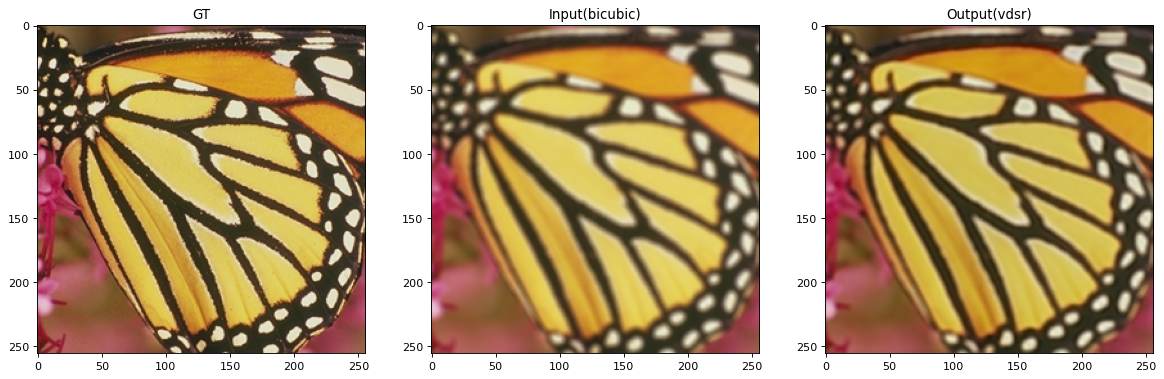

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F863553A610>,
 14.978275355850318,
 14.616350694539852)

In [65]:
display_PSNR(im_gt, im_b2, model)

# convert sample videos

In [66]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepfuzmodel2-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<00:55, 16.05it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/muffins30secpercepfuzmodel2-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [01:08<00:00, 13.10it/s]


True

In [67]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepfuzmodel2-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 9/900 [00:00<00:09, 89.53it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/muffins30secpercepfuzmodel2-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 109.91it/s]


True

In [68]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepfuzmodel2-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<00:57, 15.73it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/muffins30secpercepfuzmodel2-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [01:07<00:00, 13.38it/s]


True

In [69]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepfuzmodel2-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/muffins30secpercepfuzmodel2-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:13<00:00, 12.30it/s]


True

In [70]:
dualfile= folder + "muffins30secpercepfuzmodel2-30dual.mp4"

In [71]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [72]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [73]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8percepfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/super8percepfuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:43<00:00, 25.35it/s]


True

In [74]:

dualfile= folder + "super8percepfuzmodel2dual.mp4"

In [75]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [76]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel3.mp4"
outfile = folder + "super8percepfuzmodel1.mp4"
dualfile= folder + "super8percepfuzmodel2-tolast-dual.mp4"

In [77]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [78]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longpercepfuzmodel2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz acc training/super8longpercepfuzmodel2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:16:15<00:00, 26.53it/s]


True

In [79]:
dualfile= folder + "super8longpercepfuzmodel2dual.mp4"

In [80]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}